In [ ]:
%pylab inline
rcParams["figure.figsize"] = (16,5)
from scipy.io import wavfile
import pyworld
import pysptk
import IPython
from IPython.display import Audio
import librosa
import librosa.display

Populating the interactive namespace from numpy and matplotlib


In [15]:
from nnmnkwii import preprocessing as P

In [24]:
def compute_mgc_from_waveform(x, fs):
    frame_period=5
    order=59
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
    alpha = pysptk.util.mcepalpha(fs)
    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)   
    hop_length = int(fs * (frame_period * 0.001))
    modfs = fs / hop_length
    mc = P.modspec_smoothing(mc, modfs, cutoff=50)
    return mc

def visial_gc(ori_wav_path,base_wav_path):
    """
    visualize the mgc feature of one waveform
    ori_wav_path -- natural waveform path
    base_wav_path -- basewaveform path
    """
    ori_fs, ori_waveform = wavfile.read(ori_wav_path)
    base_fs, base_waveform = wavfile.read(base_wav_path)
    mgc_natural = compute_mgc_from_waveform(ori_waveform, ori_fs)
    mgc_baseline = compute_mgc_from_waveform(base_waveform,base_fs)
    figure(figsize=(16,6))
    plot(np.var(mgc_natural, axis=0), "--", linewidth=2, label="{0}: global variances".format('Natural'))
    plot(np.var(mgc_baseline, axis=0),linewidth=2, label="{0}: global variances".format('Baseline'))
    legend(prop={"size": 18})
    yscale("log")
    xlabel("Dimention", fontsize=16)
    print("Natural")
    IPython.display.display(Audio(ori_waveform, rate=ori_fs))
    print("Baseline")
    IPython.display.display(Audio(base_waveform,rate=base_fs))

In [25]:
base_wav_path='/home/patrick/projects/merlin/egs/slt_arctic/s1/experiments/slt_arctic_full/acoustic_model/gen/feed_forward_6_selu_2/arctic_b0408.wav'
ori_wav_path="/home/patrick/corpous/cmu_arctic/cmu_us_slt_arctic/wav/arctic_b0408.wav"

Natural


Baseline


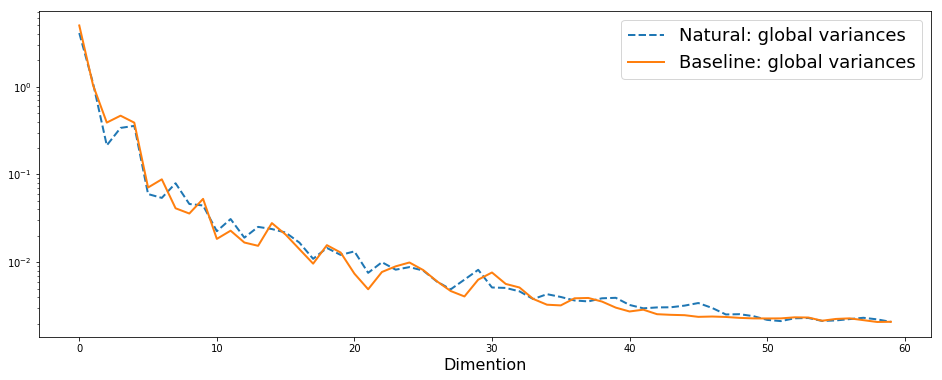

In [26]:
visial_gc(ori_wav_path=ori_wav_path,base_wav_path=base_wav_path)

In [27]:
def scatter_plots(ori_wav_path,base_wav_path):
    """
    plot the correlation of two dimension of mel cepstrum
    """
    ori_fs, ori_waveform = wavfile.read(ori_wav_path)
    base_fs, base_waveform = wavfile.read(base_wav_path)
    mgc_natural = compute_mgc_from_waveform(ori_waveform, ori_fs)
    mgc_baseline = compute_mgc_from_waveform(base_waveform,base_fs)    

    # For order=24
    dim_pairs = [(1, 3), (11, 13), (21, 23)]
    # For order=59
    # dim_pairs = [(1, 3), (11, 13), (41, 43), (51, 53), (55, 58)]
    figure(figsize=(16,6*len(dim_pairs)))

    for pair_idx, (i, j) in enumerate(dim_pairs):
        for idx, features in enumerate([mgc_natural, mgc_baseline]):
            subplot(len(dim_pairs), 3, pair_idx*3 + 1+idx)
            c = "black" if idx == 0 else "gray" if idx == 1 else "blue"
            scatter(features[:,i], features[:,j], marker="x", c=c)            
            xlim(np.min(mgc_natural[:,i])-0.03, np.max(mgc_natural[:,i])+0.03)
            ylim(np.min(mgc_natural[:,j])-0.03, np.max(mgc_natural[:,j])+0.03)
            xlabel("{}-th mel-cepstrum coefficients".format(i), fontsize=18)
            if idx == 0:
                ylabel("{}-th mel-cepstrum coefficients".format(j), fontsize=18)

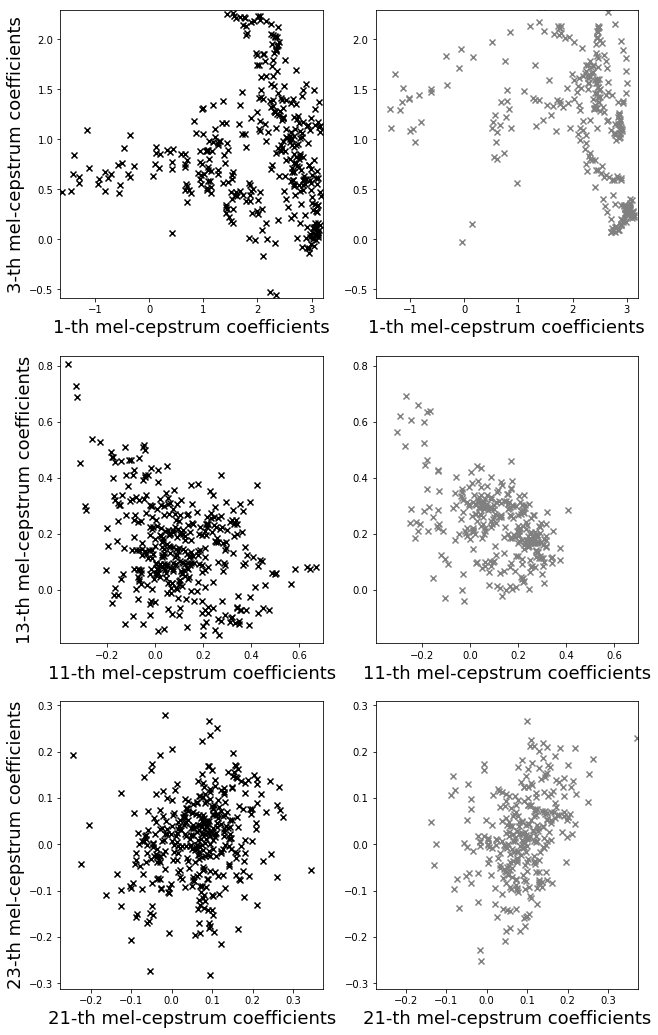

In [28]:
scatter_plots(ori_wav_path,base_wav_path)

In [34]:
def mel_trajectory(ori_wav_path,base_wav_path,dim):
    """
    plot mel-cepstral trajectories of different methods
    """
    ori_fs, ori_waveform = wavfile.read(ori_wav_path)
    base_fs, base_waveform = wavfile.read(base_wav_path)
    mgc_natural = compute_mgc_from_waveform(ori_waveform, ori_fs)
    mgc_baseline = compute_mgc_from_waveform(base_waveform,base_fs)   
    print("frame numbers of natural speech {0}, frame numbers of synthesis speech {1}".format(mgc_natural.shape[0],mgc_baseline.shape[0]))
    figure(figsize=(16,6))
    plot(mgc_natural[:,dim], "--", linewidth=2, label="natural mc")
    plot(mgc_baseline[:,dim], linewidth=2,label="synthesis mc")
    legend(prop={"size": 18})
    ylim(np.min(mgc_natural[:,dim])-0.03, np.max(mgc_natural[:,dim])+0.03)
    xlabel("{}-th mel-cepstrum coefficients".format(dim), fontsize=18)
    ylabel("frames", fontsize=18)

frame numbers of natural speech 370, frame numbers of synthesis speech 295


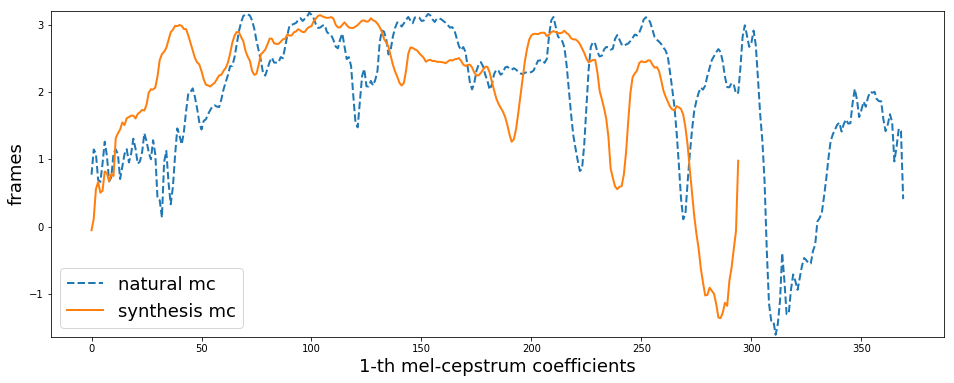

In [42]:
mel_trajectory(ori_wav_path,base_wav_path,1)

In [39]:
def mel_spec(audio_path):
    y, sr = librosa.load(audio_path)
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

    # Convert to log scale (dB). We'll use the peak power as reference.
    log_S = librosa.logamplitude(S, ref_power=np.max)

    # Make a new figure
    plt.figure(figsize=(12,4))

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

    # Put a descriptive title on the plot
    plt.title('mel power spectrogram')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()

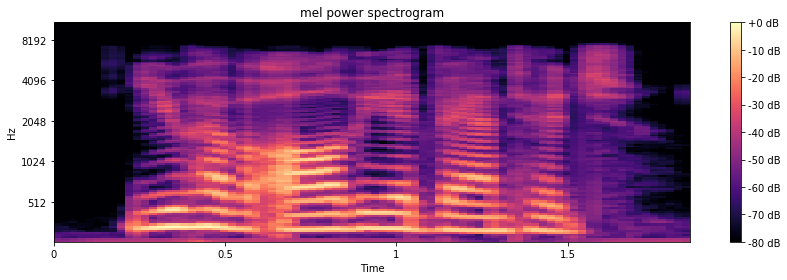

In [40]:
mel_spec(ori_wav_path)

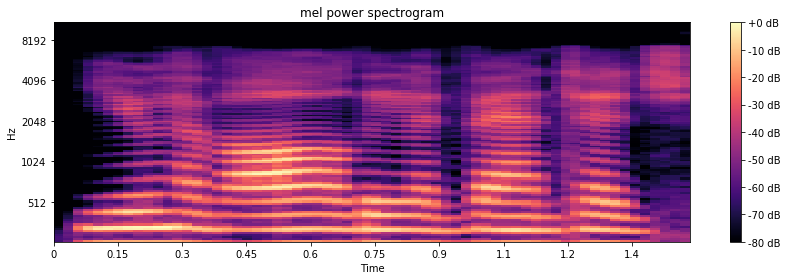

In [43]:
mel_spec(base_wav_path)